In [1]:
import sys
sys.path.insert(0, '../Utilities/')

import torch
from torch.optim import lr_scheduler
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time
from collections import deque
import math

np.random.seed(1234)
torch.manual_seed(1) 
print(torch.cuda.is_available())
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
def figsize(scale, nplots = 1):
    fig_width_pt = 390.0                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = nplots*fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

def newfig(width, nplots = 1):
    fig = plt.figure(figsize=figsize(width, nplots))
    ax = fig.add_subplot(111)
    return fig, ax

def savefig(filename, crop = True):
    if crop == True:
#        plt.savefig('{}.pgf'.format(filename), bbox_inches='tight', pad_inches=0)
        plt.savefig('{}.pdf'.format(filename), bbox_inches='tight', pad_inches=0)
        plt.savefig('{}.eps'.format(filename), bbox_inches='tight', pad_inches=0)
    else:
#        plt.savefig('{}.pgf'.format(filename))
        plt.savefig('{}.pdf'.format(filename))
        plt.savefig('{}.eps'.format(filename))

True


In [2]:
def grad(u, x):
    """ Get grad """
    gradient = torch.autograd.grad(
        u, x,
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]
    return gradient

In [3]:
import torch.nn as nn
class CustomActivation(torch.nn.Module):
    def __init__(self, num_features):
        super(CustomActivation, self).__init__()
        # Initialize trainable parameters alpha1 and d per neuron
        self.lambda1 = nn.Parameter(0.1*torch.ones(num_features))
        self.lambda2 = nn.Parameter(0.1*torch.ones(num_features))
        self.d = nn.Parameter(0.1*torch.ones(num_features))

    def forward(self, x):
        # Compute the custom activation function

        denominator = x**2 + self.d**2
        term1 = self.lambda1 * x / denominator
        term2 = self.lambda2 / denominator
        return term1 + term2


class DNN(nn.Module):
    def __init__(self, layers, activation_type='per_neuron'):
        super(DNN, self).__init__()
        self.depth = len(layers) - 1
        layer_list = []
        
        for i in range(self.depth - 1):
            # Add linear layer
            layer_list.append(('layer_%d' % i, nn.Linear(layers[i], layers[i+1])))
            
            # Add activation layer with per-neuron parameters

            layer_list.append(('activation_%d' % i, CustomActivation(layers[i+1])))

        # Add the final output layer without activation
        layer_list.append(('layer_%d' % (self.depth - 1), nn.Linear(layers[-2], layers[-1])))
        
        layerDict = OrderedDict(layer_list)
        self.layers = nn.Sequential(layerDict)
            
    def forward(self, x):
        out = self.layers(x)
        return out

class CustomLRDecayScheduler:
    def __init__(self, optimizer, lr0, decay_rate, decay_step, lr_min):
        self.optimizer = optimizer
        self.lr0 = lr0
        self.decay_rate = decay_rate
        self.decay_step = decay_step
        self.lr_min = lr_min
        self.optim_step = 0

    def step(self):
        self.optim_step += 50
        lr = self.lr0 * (self.decay_rate ** (self.optim_step / self.decay_step))
        # 检查学习率是否低于 lr_min
        if lr < self.lr_min:
            lr = self.lr_min
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        return lr

def count_parameters(model):
    return sum(p.numel() for p in model.dnn.parameters() if p.requires_grad)

def get_gpu_memory_usage():
    if torch.cuda.is_available():
        return {
            "allocated": torch.cuda.memory_allocated() / 1024 ** 2,  # MB
            "cached": torch.cuda.memory_reserved() / 1024 ** 2  # MB
        }
    return {"error": "No GPU available"}

def estimate_cpu_memory(model):
    param_size = 0
    for param in model.dnn.parameters():
        param_size += param.nelement() * param.element_size()
    
    buffer_size = 0
    for buffer in model.dnn.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    
    return param_size + buffer_size 

In [4]:
class PINN():
    """ PINN Class """
    
    def __init__(self, X_f, a, layers):
         # data
        self.x_f1 = X_f[:, 0:1].clone().detach().requires_grad_(True).float().to(device)
        self.t_f = X_f[:, 1:2].clone().detach().requires_grad_(True).float().to(device)
        self.a = a
        
        self.layers = layers
        
        self.dnn = DNN(layers).to(device)

       # Modified optimizer setup
        self.optimizer = torch.optim.Adam(self.dnn.parameters(), lr=5e-3, betas=(0.9, 0.99))


        self.scheduler = CustomLRDecayScheduler(self.optimizer, lr0=5e-3, decay_rate=0.75, decay_step=1000, lr_min = 1e-5)
        
        self.iter = 0
        self.l2_errors = []
        self.l_inf_errors = []
        self.MSE_errors = []
        self.time_list = [] 
        self.total_time = 0 

        self.rsum = 0
        self.eta = 0.001
        self.gamma = 0.999

    def net_u(self, x1,t):
        u = self.dnn(torch.cat([x1, t], dim=1))
        u_transform = u * x1 * (1 - x1) * t + 1*torch.sin(1*np.pi*x1) + 2*torch.sin(self.a*np.pi*x1)
        return u_transform

    def net_f(self, x, t):
        """
        Residual for:
            u_t = 0.5 * u_xx + f(x,t)
        with
            f(x,t) = -3 * (3*pi)**2 * sin(3*pi*x) * exp(-2*(3*pi)**2 * t)
        """
        # Forward
        u = self.net_u(x, t)

        # First derivatives
        u_x = grad(u, x)
        u_t = grad(u, t)

        # Second derivative in x
        u_xx = grad(u_x, x)

        # Forcing term f(x,t)
        a = self.a
        D = 0.5 
        f_forcing = -3.0 * (a * np.pi) ** 2 * torch.sin(a * np.pi * x) * torch.exp(-2.0 * (a * np.pi) ** 2 * t)

        f_res = u_t - D * u_xx - f_forcing
        return f_res

    def loss_func(self):
        """ Loss function """
        
        self.optimizer.zero_grad()
        
        f_pred = self.net_f(self.x_f1, self.t_f)
        
        r_norm = self.eta*torch.abs(f_pred)/torch.max(torch.abs(f_pred))
        self.rsum = (self.rsum*self.gamma + r_norm).detach()
        loss_f = torch.mean((f_pred)**2)

        # Loss calculation
        loss = loss_f
        loss.backward()
        self.iter += 1
        if self.iter % 2000 == 0:
            print(
                'Iter %d, Loss_f: %.5e' % (self.iter, loss_f.item())
            )
        return loss

    def compute_errors(self, X_star):
        """Compute L2, L_inf, and MSE errors using PyTorch (no numpy)."""
        with torch.no_grad():
            u_pred = self.predict(X_star)  # Shape: [N, 1]
            X = X_star[:, 0:1]
            T = X_star[:, 1:2]
 
            U_exact = np.sin(1*np.pi*X) * np.exp(-0.5*(np.pi**2)*T) + 2*np.sin(self.a*np.pi*X) * np.exp(-2*((self.a*np.pi)**2)*T)
            u_exact = torch.tensor(U_exact, dtype=torch.float32, device=device)
            
            # L2 Error (using PyTorch)
            l2_error = torch.linalg.norm(u_pred - u_exact) / torch.linalg.norm(u_exact)
            
            # L_inf Error
            l_inf_error = torch.max(torch.abs(u_pred - u_exact))
            
            # MSE
            mse = torch.mean((u_pred - u_exact) ** 2)
            
            self.l2_errors.append(l2_error.item())
            self.l_inf_errors.append(l_inf_error.item())
            self.MSE_errors.append(mse.item())
            
        return l2_error.item(), l_inf_error.item(), mse.item()

    def train(self, num_epochs):
        self.dnn.train()
        self.loss = []
        print(f'We are using {type(self.optimizer).__name__} optimizer for optimizer1')  
        start_time = time.time()
        for i in range(num_epochs):
            loss = self.loss_func()
            self.optimizer.step()
            if (i+1) % 50 == 0:
                self.scheduler.step()


            if i % 100 == 0 and i > 0:  # 检查是否是每 100 次迭代
                end_time = time.time()  # 记录结束时间
                elapsed_time = end_time - start_time  # 计算这 100 次迭代所花费的时间
                self.total_time += elapsed_time  # 累加总时间
                self.time_list.append(self.total_time)  # 将总时间添加到时间列表
                start_time = time.time()  # 重置开始时间
                
            if i % 100 == 0:  # Check if the current iteration is a multiple of 100
                l2, l_inf, mse = self.compute_errors(X_star)
                current_lr = self.optimizer.param_groups[0]['lr']
                print(f"Adam Epoch {i}: L2={l2:.3e}, Linf={l_inf:.3e}, MSE={mse:.3e}, Learning Rate: {current_lr:e}")

    
    def predict(self, X):
        x1 = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        self.dnn.eval()
        u = self.net_u(x1, t)
        return u.detach()

In [5]:
from scipy.stats import qmc
if __name__ == '__main__':
    
    N_f = 20000
    N_test = 90000
    layers = [2, 200, 1]
    a = 3

    # Define domain bounds for 5D (adjust to your problem)
    l_bounds = [0, 0]  # Lower bounds for each dimension
    u_bounds = [1, 1]  # Upper bounds for each dimension

    # Use Latin Hypercube Sampling (LHS) for 5D points
    sampler = qmc.LatinHypercube(d=len(l_bounds))  # d=5
    
    # Generate training points
    X_f_train = sampler.random(n=N_f)
    X_f_train = qmc.scale(X_f_train, l_bounds, u_bounds).astype(np.float32)  # Fix: Use l_bounds/u_bounds
    
    # Generate testing points
    X_star = sampler.random(n=N_test)
    X_star = qmc.scale(X_star, l_bounds, u_bounds).astype(np.float32)
    
    X_f_new = torch.from_numpy(X_f_train).float()
model = PINN(X_f_new, a, layers)

In [ ]:
%%time
# Create a new instance of the PINN2 class with the same layer configuration

model.train(num_epochs= 30001)

We are using Adam optimizer for optimizer1
Adam Epoch 0: L2=6.315e+00, Linf=2.631e+00, MSE=2.238e+00, Learning Rate: 5.000000e-03
Adam Epoch 100: L2=9.274e-01, Linf=1.610e+00, MSE=4.825e-02, Learning Rate: 4.858208e-03
Adam Epoch 200: L2=6.019e-01, Linf=1.371e+00, MSE=2.032e-02, Learning Rate: 4.720438e-03
Adam Epoch 300: L2=3.278e-01, Linf=6.689e-01, MSE=6.028e-03, Learning Rate: 4.586574e-03
Adam Epoch 400: L2=2.717e-01, Linf=6.817e-01, MSE=4.141e-03, Learning Rate: 4.456506e-03
Adam Epoch 500: L2=2.354e-01, Linf=5.467e-01, MSE=3.108e-03, Learning Rate: 4.330127e-03
Adam Epoch 600: L2=1.221e-01, Linf=2.749e-01, MSE=8.362e-04, Learning Rate: 4.207332e-03


In [10]:
np.savez_compressed(
    "stiff_data.npz",
    X_f_train=X_f_train,
    X_star=X_star,
    l_bounds=np.array(l_bounds, dtype=np.float32),
    u_bounds=np.array(u_bounds, dtype=np.float32),
)

In [11]:
np.save('XNet-stiff-l2_errors.npy',model.l2_errors)
np.save('XNet-stiff-l_inf_errors.npy',model.l_inf_errors)
np.save('XNet-stiff-time.npy',model.time_list)

L2 Error: 1.875965e-03


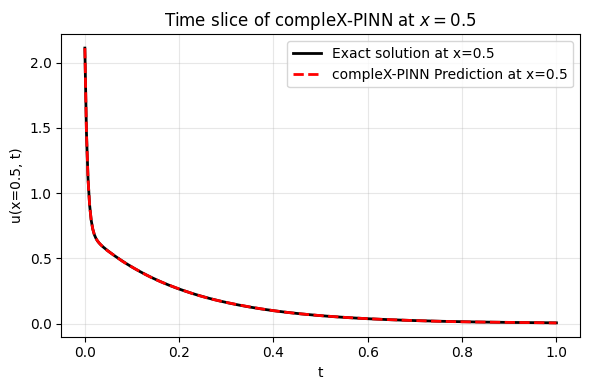

In [16]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Grids
x_f = np.linspace(0, 1, 300)
y_f = np.linspace(0, 1, 300)  # time grid
X, T = np.meshgrid(x_f, y_f)
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# Model prediction on the flattened grid
u_pred = model.predict(X_star).cpu().detach().numpy()           # shape (N,1) or (N,)
u_pred = np.asarray(u_pred).reshape(-1, 1)
# If it's a torch tensor, you did: u_pred = u_pred.detach().cpu().numpy()

# Exact solution
U_exact = (np.sin(1*np.pi*X) * np.exp(-0.5*(np.pi**2)*T)
           + 2*np.sin(3*np.pi*X) * np.exp(-2*((3*np.pi)**2)*T))
u_exact = U_exact.reshape(-1, 1)

# L2 relative error on the flattened grid
norm_diff = np.linalg.norm(u_exact - u_pred)
norm_star = np.linalg.norm(u_exact)
error_u = norm_diff / norm_star
print('L2 Error: %e' % (error_u))

# Reshape prediction back to grid for visualization
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(U_exact - U_pred)

# Pick the column closest to x = 0.5
x0 = 0.75
ix = np.argmin(np.abs(x_f - x0))

# Extract time vector and the two slices
t_slice = y_f                                # same as T[:, ix]
u_exact_slice = U_exact[:, ix]               # exact u(t) at x ~ 0.5
u_pred_slice = U_pred[:, ix]                 # predicted u(t) at x ~ 0.5

# Optional: handle any NaNs from interpolation at edges
mask = ~np.isnan(u_pred_slice)
t_plot = t_slice[mask]
u_exact_plot = u_exact_slice[mask]
u_pred_plot = u_pred_slice[mask]

# Plot time slice at x ≈ 0.5
plt.figure(figsize=(6,4))
plt.plot(t_plot, u_exact_plot, 'k-', lw=2, label='Exact solution at x=0.5')
plt.plot(t_plot, u_pred_plot, 'r--', lw=2, label='compleX-PINN Prediction at x=0.5')
plt.xlabel('t')
plt.ylabel('u(x=0.5, t)')
plt.title(r'Time slice of compleX-PINN at $x = 0.5$')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
# ============ SAVE MODEL 1 PREDICTIONS ============
np.savez('XNetmodel_predictions_0.75.npz', 
         t=t_plot,
         u_exact=u_exact_plot,
         u_pred=u_pred_plot,
         L2_error=error_u)

print(f"Saved Model 1 predictions to 'RBAmodel_predictions_0.75.npz'")
print(f"L2 Error: {error_u:.6e}")

Saved Model 1 predictions to 'RBAmodel_predictions_0.75.npz'
L2 Error: 1.875965e-03


In [ ]:
data1 = np.load('RBAmodel_predictions_0.5.npz')
t_plot1 = data1['t']
u_exact_plot1 = data1['u_exact']
u_pred_plot1 = data1['u_pred']
error_u1 = data1['L2_error']

print('Model 1 L2 Error (loaded): %e' % (error_u1))

# ============ PLOT BOTH MODELS TOGETHER ============
plt.figure(figsize=(10, 6))

# Plot exact solution (only once)
plt.plot(t_plot, u_exact_plot, 'k-', lw=2.5, label='Exact @ x=0.5')

# Plot Model 1 predictions (loaded)
plt.plot(t_plot1, u_pred_plot1, 'r--', lw=2, 
         label=f'Model 1 (L2: {error_u1:.3e})', alpha=0.8)

# Plot Model 2 predictions (current)
plt.plot(t_plot, u_pred_plot, 'b--', lw=2, 
         label=f'Model 2 (L2: {error_u:.3e})', alpha=0.8)

plt.xlabel('Time t', fontsize=12)
plt.ylabel('u(x=0.5, t)', fontsize=12)
plt.title('Comparison: Model 1 vs Model 2 at x = 0.5', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='best', fontsize=11)
plt.tight_layout()
plt.show()

# ============ PRINT COMPARISON ============
print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)
print(f"Model 1 L2 Error: {error_u1:.6e}")
print(f"Model 2 L2 Error: {error_u:.6e}")
print("="*50)
if error_u < error_u1:
    improvement = (error_u1 - error_u) / error_u1 * 100
    print(f"Model 2 is better by {improvement:.1f}%")
else:
    degradation = (error_u - error_u1) / error_u1 * 100
    print(f"Model 1 is better by {degradation:.1f}%")

# ============ OPTIONAL: SAVE MODEL 2 FOR FUTURE USE ============
np.savez('XNetmodel_predictions_0.5.npz', 
         t=t_plot,
         u_exact=u_exact_plot,
         u_pred=u_pred_plot,
         L2_error=error_u)
print(f"\nSaved Model 2 predictions to 'model2_predictions.npz'")

In [ ]:
x_f = np.linspace(0 , 1, 300)
y_f = np.linspace(0 , 1, 300)
    
X, T = np.meshgrid(x_f, y_f)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_pred = model.predict(X_star)
u_pred = u_pred.detach().cpu().numpy()
# Compute the exact solution

U_exact = 1*np.sin(1*np.pi*X) * np.exp(-0.5*(np.pi**2)*T) + 2*np.sin(3*np.pi*X) * np.exp(-2*((3*np.pi)**2)*T)
u_exact = U_exact.reshape(-1 ,1)
norm_diff = np.sqrt(np.sum((u_exact  - u_pred)**2))
norm_star = np.sqrt(np.sum((u_exact)**2))
error_u = norm_diff / norm_star
print('L2 Error: %e' % (error_u))                 

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(U_exact- U_pred)

In [ ]:
import matplotlib.tri as tri
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import seaborn as sn
X_star_total = np.vstack((X_star))
x_total = X_star_total[:, 0:1]
y_total = X_star_total[:, 1:2]

# Create a Triangulation instance
triang_total = tri.Triangulation(x_total.flatten(), y_total.flatten())

fig, ax = plt.subplots(figsize=(11, 7))

# Plot u_pred using tricontourf
contour = ax.tricontourf(triang_total, u_exact.flatten(), 100, cmap='jet')
tcbar = fig.colorbar(contour)
tcbar.ax.tick_params(labelsize=18)
ax.set_xlabel('$x$', fontsize = 18)
ax.set_ylabel('$y$', fontsize = 18)
ax.tick_params(axis="x", labelsize = 20)
ax.tick_params(axis="y", labelsize = 20)  
#ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5)) 
ax.set_title('Exact solution', fontsize = 24)
plt.savefig(r"C:\Users\admin\Desktop\output\XNet\stiff\Stiff-Exact",dpi = 300)
plt.show()

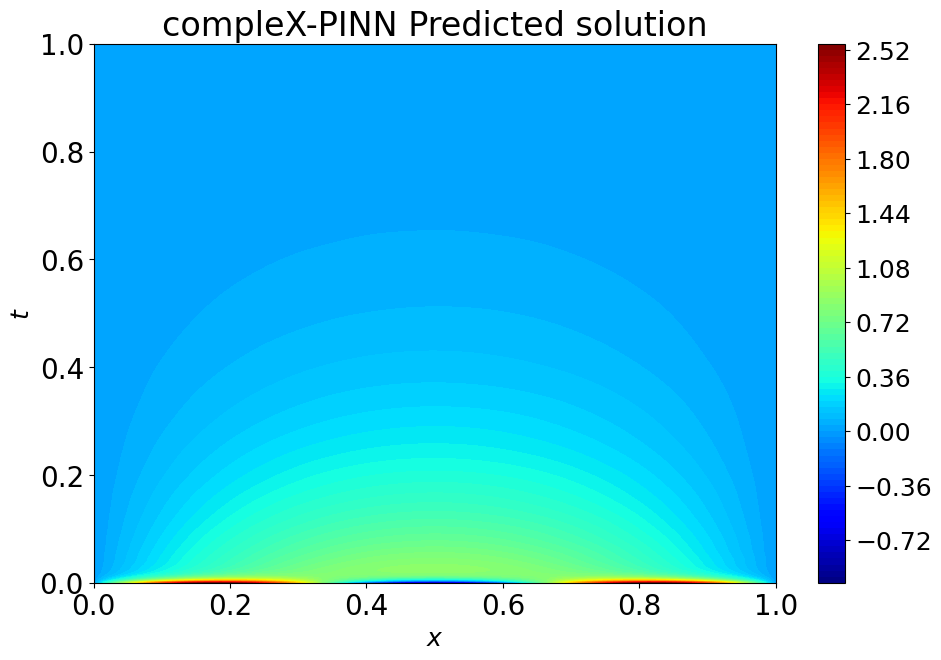

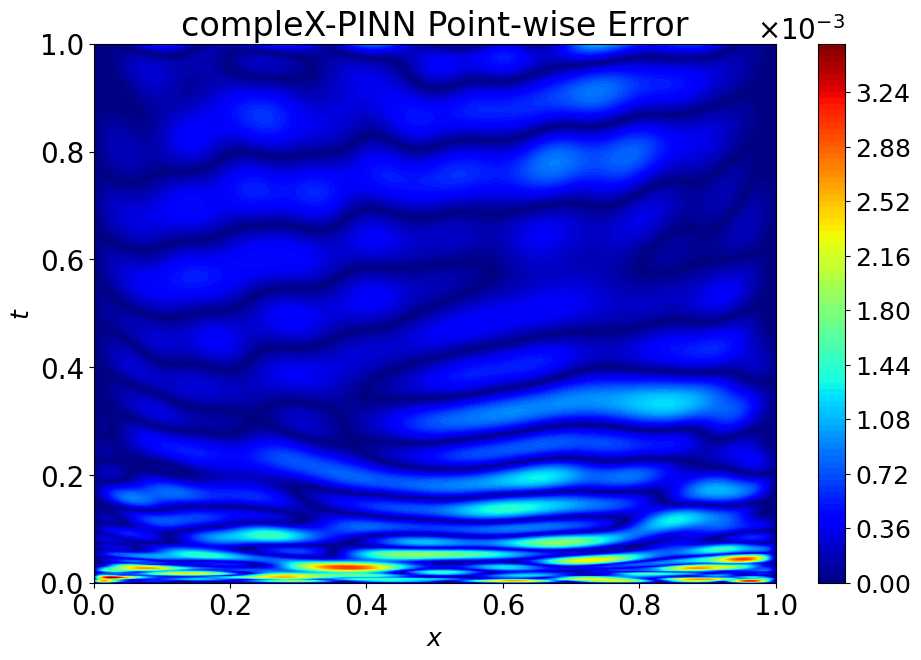

In [18]:
import matplotlib.tri as tri
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import seaborn as sn
u_pred = np.concatenate([u_pred])

X_star_total = np.vstack((X_star))
x_total = X_star_total[:, 0:1]
y_total = X_star_total[:, 1:2]

# Create a Triangulation instance
triang_total = tri.Triangulation(x_total.flatten(), y_total.flatten())

fig, ax = plt.subplots(figsize=(11, 7))

# Plot u_pred using tricontourf
contour = ax.tricontourf(triang_total, u_pred.flatten(), 100, cmap='jet')
tcbar = fig.colorbar(contour)
tcbar.ax.tick_params(labelsize=18)
ax.set_xlabel('$x$', fontsize = 18)
ax.set_ylabel('$t$', fontsize = 18)
ax.tick_params(axis="x", labelsize = 20)
ax.tick_params(axis="y", labelsize = 20)  
#ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5)) 
ax.set_title('compleX-PINN Predicted solution', fontsize = 24)
plt.savefig(r"C:\Users\admin\Desktop\output\XNet\stiff\stiff-XNet-Pred",dpi = 300)
plt.show()

# Plot the error
fig, ax = plt.subplots(figsize=(11, 7))
contour = ax.contourf(X, T, Error, 100, cmap='jet')
tcbar = fig.colorbar(contour)
tcbar.ax.tick_params(labelsize=18)
ax.set_xlabel('$x$', fontsize = 18)
ax.set_ylabel('$t$', fontsize = 18)
ax.tick_params(axis="x", labelsize = 20)
ax.tick_params(axis="y", labelsize = 20)  
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, 2))
tcbar.ax.yaxis.set_major_formatter(formatter)
# Make the scientific notation label larger
tcbar.ax.yaxis.offsetText.set_fontsize(20)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(0.25))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(0.25))
ax.set_title('compleX-PINN Point-wise Error', fontsize = 24)
plt.savefig(r"C:\Users\admin\Desktop\output\XNet\stiff\stiff-XNet-Error",dpi = 300)
plt.show()

In [19]:
np.max(Error)

np.float64(0.0035476408484500788)